# Good Code

## Libraries

In [1]:
import sys
from pathlib import Path
import os

# FOR LOCAL USE THIS LINE
NOTEBOOK_DIR = Path.cwd()
REPO_ROOT = NOTEBOOK_DIR.parent.parent

# FOR COLAB USE THIS LINE INSTEAD
#!git clone https://github.com/MatteoCamillo-code/GeoLoc-CVCS.git
#REPO_ROOT = Path("/content/GeoLoc-CVCS").resolve()

SRC_DIR = REPO_ROOT / "src"
DATA_DIR = REPO_ROOT / "data"
CHECKPOINT_DIR = REPO_ROOT / "outputs" / "checkpoints"
CHECKPOINT_DIR.mkdir(exist_ok=True, parents=True)

sys.path.insert(0, str(SRC_DIR))


In [2]:
from dataset.osv_dataset import OSV_mini
import pandas as pd
import torch
from torch.utils.data import DataLoader
import numpy as np
from torchvision import transforms
import geopandas as gpd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time

In [3]:
import torch.multiprocessing as mp
mp.set_start_method("spawn", force=True)

## Setup

Loading the OSVmini dataset from Kaggle

In [4]:
#!pip install kagglehub
import kagglehub

path = kagglehub.dataset_download("josht000/osv-mini-129k")
path = path+'/osv5m'

print("Path to dataset files:", path)

c:\Users\camil\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\camil\.cache\kagglehub\datasets\josht000\osv-mini-129k\versions\1/osv5m


Extracting Training/Validation Set Metadata and cell centroids

In [5]:
train_val_meta = pd.read_csv(DATA_DIR / "metadata/s2-geo-cells/train_val_split_geocells.csv")
train_val_meta.head()

,id,latitude,longitude,thumb_original_url,country,sequence,captured_at,lon_bin,lat_bin,cell,...,unique_city,unique_country,creator_username,creator_id,predicted_label,s2_cell,is_train,label_config_1,label_config_2,label_config_3
0,175846147796767,31.807977,-109.051129,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,ufvI_dqzSv-GNnWH7SrduA,1460743210350,18.0,64.0,"(18, 64)",...,Lordsburg_Hidalgo County_New Mexico_US,US,adotgis,1.005834e+14,Natural,CellId: 86d991cde1b03a05,1,86d99,86d99,86d9
1,327253605472404,31.805039,-109.053170,https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...,US,ufvI_dqzSv-GNnWH7SrduA,1460743197630,18.0,64.0,"(18, 64)",...,Lordsburg_Hidalgo County_New Mexico_US,US,adotgis,1.005834e+14,Natural,CellId: 86d991d1b8c7fbd3,1,86d99,86d99,86d9
2,815733012693812,31.839720,-109.029062,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,crag9qhk6sw89qnqvs1v0p,1460300841441,18.0,64.0,"(18, 64)",...,Lordsburg_Hidalgo County_New Mexico_US,US,drkludge,1.106021e+14,Natural,CellId: 86d990591818b4a1,1,86d99,86d99,86d9
3,471207127297520,31.812350,-109.048174,https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...,US,8TlCI49QRTixfJhGqyDSNQ,1460743448990,18.0,64.0,"(18, 64)",...,Lordsburg_Hidalgo County_New Mexico_US,US,adotgis,1.005834e+14,Natural,CellId: 86d991cc873be437,1,86d99,86d99,86d9
4,1482670018574640,31.834722,-109.032378,https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...,US,crag9qhk6sw89qnqvs1v0p,1460300880086,18.0,64.0,"(18, 64)",...,Lordsburg_Hidalgo County_New Mexico_US,US,drkludge,1.106021e+14,Natural,CellId: 86d9905a63f65097,1,86d99,86d99,86d9


In [6]:


cell_centers_df = pd.read_csv(DATA_DIR / "metadata/s2-geo-cells/cell_center_dataset.csv")
cell_centers_df.head()

,cell_id_token,center_latitude,center_longitude,count,config_name
0,86d84,32.648380,-109.188005,5,config_1
1,86d904,32.286026,-108.712579,42,config_1
2,86d914,32.139738,-108.522571,1,config_1
3,86d91c,32.314937,-108.522571,8,config_1
4,86d99,31.804084,-108.997769,6,config_1


## Data Exploration and Visualization

Obtaining the US countries' borders for plotting

In [7]:
# Country borders
countries_url = (
    "https://naturalearth.s3.amazonaws.com/110m_cultural/"
    "ne_110m_admin_0_countries.zip"
)

# State / province borders
states_url = (
    "https://naturalearth.s3.amazonaws.com/110m_cultural/"
    "ne_110m_admin_1_states_provinces.zip"
)

world = gpd.read_file(countries_url)
states = gpd.read_file(states_url)

usa = world[world["NAME"] == "United States of America"]
usa_states = states[states["admin"] == "United States of America"]


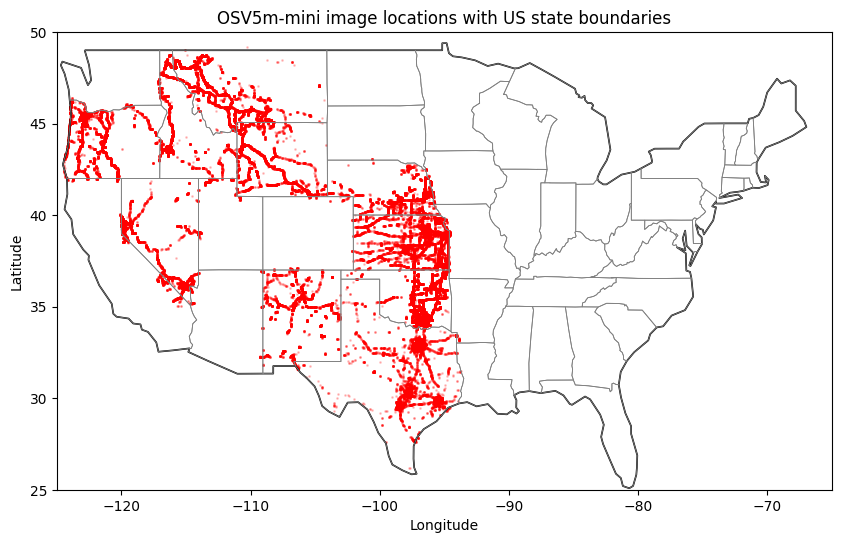

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

# US country outline
usa.boundary.plot(ax=ax, linewidth=1.2, color="black")

# State boundaries
usa_states.boundary.plot(ax=ax, linewidth=0.6, color="gray")

# Overlay image locations
ax.scatter(
    train_val_meta["longitude"],
    train_val_meta["latitude"],
    s=1,
    alpha=0.2,
    color="red"
)



# Continental US bounds
ax.set_xlim(-125, -65)
ax.set_ylim(25, 50)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("OSV5m-mini image locations with US state boundaries")

plt.show()


## Torch Dataset

Defining a torch.Dataset class to upload and handle the dataset to the neural networks

In [9]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0), ratio=(3/4, 4/3)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.05),
    transforms.RandomApply([transforms.RandomRotation(10)], p=0.2),
    transforms.ToTensor(),
])

In [10]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [11]:
# train_dataset = OSV_mini(path+'/train_images', "datasets/train_val_final.csv", train_transform, split = 'train')
# val_dataset = OSV_mini(path+'/train_images', "datasets/train_val_final.csv", train_transform, split = 'val')

image_root = path + '/train_images'
train_val_path = DATA_DIR / "metadata/s2-geo-cells/train_val_split_geocells.csv"
train_tfms = train_transform
val_tfms = val_transform

# (re)create datasets using OSV_mini from the module
train_dataset = OSV_mini(image_root, 
                         train_val_path, 
                         transform=train_tfms, 
                         split="train", 
                         scene="total")
val_dataset   = OSV_mini(image_root, 
                         train_val_path, 
                         transform=val_tfms,   
                         split="val",   
                         scene="total", 
                         label_maps=train_dataset.label_maps)


## DataLoaders

Defining a torch.DataLoader for efficient parallel loading of the dataset

In [12]:
BATCH_SIZE = 128
NUM_WORKERS = 8
PREFETCH_FACTOR = 2

train_loader = DataLoader(train_dataset,
                          shuffle=True,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          pin_memory=True,
                          prefetch_factor=PREFETCH_FACTOR,
                          drop_last=False,
                          persistent_workers=True)

val_loader = DataLoader(val_dataset,
                            shuffle=False,
                            batch_size=BATCH_SIZE,
                            num_workers=NUM_WORKERS,
                            pin_memory=True,
                            prefetch_factor=PREFETCH_FACTOR,
                            drop_last=False,
                            persistent_workers=True)


## Baseline classifier

### Model Initialization

Instantiating the Resnet50 and loading the pretrained weights

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [14]:
# Resetting the model
model = None
weights = None

In [15]:
from torchvision.models import resnet50, ResNet50_Weights

weights = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights=weights)
# model.eval()

In [16]:
# import torch._dynamo
# torch._dynamo.config.suppress_errors = True

In [17]:
PARTITION_IDX = 1

num_classes = [train_val_meta['label_config_1'].nunique(),
               train_val_meta['label_config_2'].nunique(),
               train_val_meta['label_config_3'].nunique()]

in_features = model.fc.in_features # always 2048
model.fc = nn.Linear(in_features, num_classes[PARTITION_IDX])

model = model.to(device)

model = torch.compile(model, backend="aot_eager")

In [18]:
# Freeze all parameters in the model initially
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final fully connected layer (model.fc)
# This layer was replaced with a new nn.Linear layer in cell nYgB9PL73PAb
for param in model.fc.parameters():
    param.requires_grad = True

### Functions

In [19]:
def compute_gps_distance(x1: torch.Tensor, x2: torch.Tensor) -> torch.Tensor:
    """
    Compute the great-circle distance (Haversine) between two GPS points.

    Args:
        x1: Tensor of shape (..., 2) -> (lat, lon) in degrees
        x2: Tensor of shape (..., 2) -> (lat, lon) in degrees

    Returns:
        Tensor of distances in kilometers, shape (...)
    """
    # Earth radius in km
    R = 6371.0

    lat1, lon1 = torch.deg2rad(x1[..., 0]), torch.deg2rad(x1[..., 1])
    lat2, lon2 = torch.deg2rad(x2[..., 0]), torch.deg2rad(x2[..., 1])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = (
        torch.sin(dlat / 2) ** 2
        + torch.cos(lat1) * torch.cos(lat2) * torch.sin(dlon / 2) ** 2
    )

    c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1 - a))
    return R * c


In [20]:
def compute_accuracy_within_range(
    y_pred: torch.Tensor,
    y: torch.Tensor,
    distance_threshold: float):
    """
    Compute accuracy of predictions within a given distance threshold.

    Args:
        y_pred: Tensor [N, 2] predicted GPS (lat, lon)
        y: Tensor [N, 2] ground truth GPS (lat, lon)
        distance_threshold: threshold in km

    Returns:
        Accuracy as float in [0, 1]
    """
    distances = compute_gps_distance(y_pred, y)
    correct = (distances <= distance_threshold).float()
    return correct.mean().item()


In [21]:
def geo_accuracy_table(
    y_pred: torch.Tensor,
    y: torch.Tensor,
    thresholds: list):
    """
    Compute and print geo-localization accuracy for multiple distance thresholds.

    Args:
        y_pred: Tensor [N, 2] predicted GPS
        y: Tensor [N, 2] ground truth GPS
        thresholds: list of distance thresholds in km

    Returns:
        dict {threshold: accuracy}
    """
    results = {}

    print("\nGeo-localization accuracy:")
    print("----------------------------------")
    print(f"{'Threshold (km)':>15} | {'Accuracy (%)':>12}")
    print("----------------------------------")

    for t in thresholds:
        acc = compute_accuracy_within_range(y_pred, y, t)
        results[t] = acc
        print(f"{t:>15.1f} | {acc * 100:>12.2f}")

    print("----------------------------------")
    return results


In [22]:
def evaluate_geo(model, iterator, device, cell_centers_df, train_dataset_for_labels, thresholds_km):
    model.eval()

    # Identifichiamo la configurazione corretta per evitare duplicati nel lookup
    current_config = f'config_{PARTITION_IDX + 1}'
    filtered_centers = cell_centers_df[cell_centers_df['config_name'] == current_config]
    cell_centers_lookup = filtered_centers.set_index('cell_id_token')

    partition_col_name = f'label_config_{PARTITION_IDX + 1}'
    label_map_strings = train_dataset_for_labels.label_maps[partition_col_name]

    all_preds_gps = []
    all_gts_gps = []

    with torch.no_grad():
        for x, labels, gps_gt in tqdm(iterator, leave=False, desc="Geo-eval"):
            x = x.to(device, non_blocking=True)
            gps_gt = gps_gt.to(device, non_blocking=True)

            with torch.amp.autocast("cuda"):
                logits = model(x)
                predicted_class_indices = logits.argmax(dim=1).cpu().numpy()

            # Mapping indici -> S2 Token
            predicted_s2_cells = label_map_strings[predicted_class_indices]

            # Recupero coordinate (grazie al filtro iniziale, ora predicted_gps avrà la stessa size di gps_gt)
            predicted_latlons_df = cell_centers_lookup.loc[predicted_s2_cells, ['center_latitude', 'center_longitude']]
            predicted_gps = torch.tensor(predicted_latlons_df.values, dtype=torch.float32).to(device)

            all_preds_gps.append(predicted_gps)
            all_gts_gps.append(gps_gt)

    y_pred_gps = torch.cat(all_preds_gps, dim=0)
    y_true_gps = torch.cat(all_gts_gps, dim=0)

    accs = {
        t: compute_accuracy_within_range(y_pred_gps, y_true_gps, t)
        for t in thresholds_km
    }

    return accs


def evaluate_geo_fast(model, iterator, device, cell_centers_lookup, label_map_strings, thresholds_km, sample_size=None):
    """
    OPTIMIZED geo evaluation that reuses pre-computed lookup tables.
    Optionally samples N batches from iterator instead of using all.
    """
    model.eval()
    all_preds_gps = []
    all_gts_gps = []
    batch_count = 0

    with torch.no_grad():
        for x, labels, gps_gt in tqdm(iterator, leave=False, desc="Geo-eval"):
            x = x.to(device, non_blocking=True)
            gps_gt = gps_gt.to(device, non_blocking=True)

            with torch.amp.autocast("cuda"):
                logits = model(x)
                predicted_class_indices = logits.argmax(dim=1).cpu().numpy()

            predicted_s2_cells = label_map_strings[predicted_class_indices]
            predicted_latlons_df = cell_centers_lookup.loc[predicted_s2_cells, ['center_latitude', 'center_longitude']]
            predicted_gps = torch.tensor(predicted_latlons_df.values, dtype=torch.float32).to(device)

            all_preds_gps.append(predicted_gps)
            all_gts_gps.append(gps_gt)
            
            batch_count += 1
            if sample_size is not None and batch_count >= sample_size:
                break

    y_pred_gps = torch.cat(all_preds_gps, dim=0)
    y_true_gps = torch.cat(all_gts_gps, dim=0)

    accs = {
        t: compute_accuracy_within_range(y_pred_gps, y_true_gps, t)
        for t in thresholds_km
    }

    return accs


In [23]:
def calculate_accuracy(y_pred, y):
    preds = y_pred.argmax(dim=1)
    return (preds == y).float().mean()

In [24]:
def train(model, iterator, optimizer, criterion, scaler, device, partition_idx, valid_iterator, log_every=20):
    model.train()

    # accumuli su GPU (niente .item() per batch)
    loss_sum = torch.zeros((), device=device)
    acc_sum  = torch.zeros((), device=device)
    n_batches = 0

    pbar = tqdm(iterator, leave=False, desc="Training", dynamic_ncols=True)

    for i, (x, y_all, _) in enumerate(pbar):
        x = x.to(device, non_blocking=True)
        y_all = y_all.to(device, non_blocking=True)
        y = y_all[:, partition_idx]

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            y_pred = model(x)
            loss = criterion(y_pred, y)
            acc  = (y_pred.argmax(dim=1) == y).float().mean()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loss_sum += loss.detach()
        acc_sum  += acc.detach()
        n_batches += 1

        if (i + 1) % log_every == 0:
            # solo ogni N batch facciamo item() (meno sync)
            pbar.set_postfix(
                loss=f"{(loss_sum / n_batches).item():.4f}",
                acc=f"{((acc_sum / n_batches) * 100).item():.2f}%"
            )

    train_loss = (loss_sum / n_batches).item()
    train_acc  = (acc_sum / n_batches).item()

    # ---- VALIDATION ----
    model.eval()
    val_loss_sum = torch.zeros((), device=device)
    val_acc_sum  = torch.zeros((), device=device)
    val_batches = 0

    with torch.inference_mode():
        valid_pbar = tqdm(valid_iterator, leave=False, desc="Validation", dynamic_ncols=True)
        for x, y_all, _ in valid_pbar:
            x = x.to(device, non_blocking=True)
            y_all = y_all.to(device, non_blocking=True)
            y = y_all[:, partition_idx]
            
            with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                y_pred = model(x)
                loss = criterion(y_pred, y)
                acc  = (y_pred.argmax(dim=1) == y).float().mean()

            val_loss_sum += loss.detach()
            val_acc_sum  += acc.detach()
            val_batches += 1

    val_loss = (val_loss_sum / val_batches).item()
    val_acc  = (val_acc_sum / val_batches).item()

    return train_loss, train_acc, val_loss, val_acc


In [ ]:
def model_training(
    max_epochs,
    patience,
    model,
    train_iterator,
    valid_iterator,
    test_iterator,
    optimizer,
    criterion,
    scaler,
    device,
    partition_idx,
    cell_centers_df,
    train_dataset_for_labels,
    geo_thresholds=(1, 5, 25, 100),
    model_name="best_model",
    scheduler=None
):
    checkpoint_path = CHECKPOINT_DIR / (model_name + f".pt")
    best_valid_acc = 0.0
    epochs_no_improve = 0  # Contatore per early stopping

    train_losses, train_accs = [], []
    valid_losses, valid_accs = [], [] # Nota: valid_loss nel tuo schema originale non era calcolata, l'ho lasciata per coerenza

    geo_history_val = {t: [] for t in geo_thresholds}
    geo_history_test = {t: [] for t in geo_thresholds}
    
    # Pre-compute lookup tables for validation (avoid recomputing every validation)
    current_config = f'config_{partition_idx + 1}'
    filtered_centers = cell_centers_df[cell_centers_df['config_name'] == current_config]
    cell_centers_lookup = filtered_centers.set_index('cell_id_token')
    partition_col_name = f'label_config_{partition_idx + 1}'
    label_map_strings = train_dataset_for_labels.label_maps[partition_col_name]

    for epoch in range(max_epochs):
        start_time = time.time()

        # ---------------- TRAIN ----------------
        train_loss, train_acc, val_loss, val_acc = train(
            model,
            train_iterator,
            optimizer,
            criterion,
            scaler,
            device,
            partition_idx,
            valid_iterator,
        )

        # ---------------- LOGGING ----------------
        elapsed = time.time() - start_time
        print(f"\nEpoch {epoch+1}/{max_epochs} — {elapsed:.2f}s")
        print("---------------------------------------")
        print(f"Train   | Loss: {train_loss:.3f}   Acc: {train_acc*100:.2f}%")
        print(f"Validation   | Loss: {val_loss:.3f}   Acc: {val_acc*100:.2f}%")


        # ---------------- EARLY STOPPING & SAVING ----------------
        if val_acc > best_valid_acc:
            best_valid_acc = val_acc
            epochs_no_improve = 0
            # Salviamo il modello migliore
            torch.save(model.state_dict(), checkpoint_path)
            print(f"--- Modello migliorato! Salvato as {model_name} ---")
        else:
            epochs_no_improve += 1
            print(f"--- Nessun miglioramento per {epochs_no_improve} epoche ---")

        if epochs_no_improve >= patience:
            print(f"\nEARLY STOPPING attivato alla {epoch+1} epoca.")
            break

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        valid_losses.append(val_loss) # Aggiungi se calcoli la val_loss
        valid_accs.append(val_acc)
        # ---------------- LEARNING RATE SCHEDULER ----------------
        if scheduler is not None:
            scheduler.step()
            print(f"Current LR: {scheduler.get_last_lr()[0]:.6f}")
            
    # ---------------- GEO VALIDATION ----------------
    
    if valid_iterator is not None:
        
        geo_val = evaluate_geo_fast(
            model, 
            valid_iterator, 
            device, 
            cell_centers_lookup,
            label_map_strings,
            geo_thresholds,
        )
        for t, v in geo_val.items():
            geo_history_val[t].append(v)

        print("Geo Val |", end=" ")
        for t in geo_thresholds:
            print(f"≤{t}km: {geo_val[t]*100:.1f}%", end="  ")
        print()

    # ---------------- PLOTS ----------------
    plt.figure(figsize=(10, 5))
    plt.plot(valid_accs, label=f"Validation Accuracy")

    plt.xlabel("Epoch")
    plt.ylabel("Geo Accuracy")
    plt.title("Geo-accuracy over epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Carichiamo i pesi migliori prima di restituire il modello
    model.load_state_dict(torch.load(checkpoint_path))

    return (
        train_losses,
        train_accs,
        valid_losses,
        valid_accs,
        geo_history_val,
        geo_history_test,
    )


In [26]:
def plot_results(n_epochs, train_losses, train_accs, valid_losses, valid_accs):
  N_EPOCHS = n_epochs
  # Plot results
  plt.figure(figsize=(20, 6))
  _ = plt.subplot(1,2,1)
  plt.plot(np.arange(N_EPOCHS)+1, train_losses, linewidth=3)
  if valid_losses is not None:
    plt.plot(np.arange(N_EPOCHS)+1, valid_losses, linewidth=3)
    _ = plt.legend(['Train', 'Validation'])
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Loss')

  _ = plt.subplot(1,2,2)
  plt.plot(np.arange(N_EPOCHS)+1, train_accs, linewidth=3)
  if valid_accs is not None:
    plt.plot(np.arange(N_EPOCHS)+1, valid_accs, linewidth=3)
    _ = plt.legend(['Train', 'Validation'])
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Accuracy')

### Model Training

In [30]:
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.SGD(
    model.parameters(),
    lr=0.005,
    momentum=0.9,
    weight_decay=1e-4,
    nesterov=True
)
scheduler = StepLR(optimizer, step_size=5, gamma=0.7)  # Halve LR every 5 epochs
scaler = torch.amp.GradScaler("cuda")

In [ ]:
#script per provare modifiche, usa un piccolo subset con OPTIMIZATIONS

from torch.utils.data import Subset

# 1. Definiamo quante immagini usare (es. 1000 per train, 200 per val)
n_train_samples = 1000
n_val_samples = 300

# 2. Creiamo i Subset
subset_train_indices = range(min(n_train_samples, len(train_dataset)))
subset_val_indices = range(min(n_val_samples, len(val_dataset)))

train_loader_subset = DataLoader(Subset(train_dataset, subset_train_indices), batch_size=128, shuffle=True)
val_loader_subset = DataLoader(Subset(val_dataset, subset_val_indices), batch_size=128, shuffle=False)

# 3. Lanciamo il training usando i loader limitati + OPTIMIZATION FLAGS
train_losses, train_accs, valid_losses, valid_accs, geo_history_val, geo_history_test = model_training(
    max_epochs=10,
    patience=4,
    model=model,
    train_iterator=train_loader_subset,
    valid_iterator=val_loader_subset,
    test_iterator=None,
    optimizer=optimizer,
    criterion=criterion,
    scaler=scaler,
    device=device,
    partition_idx=PARTITION_IDX,
    cell_centers_df=cell_centers_df,
    train_dataset_for_labels=train_dataset,
    geo_thresholds=(1, 5, 25, 100),
    model_name="first_try_subset.pt",
    scheduler=scheduler
)



Epoch 1/30 — 208.17s
---------------------------------------
Train   | Loss: 7.698   Acc: 1.06%
Validation   | Loss: 7.572   Acc: 2.55%
--- Modello migliorato! Salvato as first_try.pt ---
Current LR: 0.005000



Epoch 2/30 — 168.00s
---------------------------------------
Train   | Loss: 7.451   Acc: 3.88%
Validation   | Loss: 7.371   Acc: 4.50%
--- Modello migliorato! Salvato as first_try.pt ---
Current LR: 0.005000



Epoch 3/30 — 166.89s
---------------------------------------
Train   | Loss: 7.257   Acc: 5.82%
Validation   | Loss: 7.213   Acc: 6.39%
--- Modello migliorato! Salvato as first_try.pt ---
Current LR: 0.005000



Epoch 4/30 — 167.03s
---------------------------------------
Train   | Loss: 7.088   Acc: 7.65%
Validation   | Loss: 7.063   Acc: 7.72%
--- Modello migliorato! Salvato as first_try.pt ---
Current LR: 0.005000



Epoch 5/30 — 167.24s
---------------------------------------
Train   | Loss: 6.934   Acc: 9.10%
Validation   | Loss: 6.927   Acc: 8.95%
--- Modello migliorato! Salvato as first_try.pt ---
Current LR: 0.003500



Epoch 6/30 — 167.03s
---------------------------------------
Train   | Loss: 6.808   Acc: 10.38%
Validation   | Loss: 6.844   Acc: 9.56%
--- Modello migliorato! Salvato as first_try.pt ---
Current LR: 0.003500



Epoch 7/30 — 167.13s
---------------------------------------
Train   | Loss: 6.712   Acc: 11.27%
Validation   | Loss: 6.763   Acc: 10.30%
--- Modello migliorato! Salvato as first_try.pt ---
Current LR: 0.003500



Epoch 8/30 — 167.14s
---------------------------------------
Train   | Loss: 6.622   Acc: 11.96%
Validation   | Loss: 6.680   Acc: 10.92%
--- Modello migliorato! Salvato as first_try.pt ---
Current LR: 0.003500



Epoch 9/30 — 167.15s
---------------------------------------
Train   | Loss: 6.536   Acc: 12.73%
Validation   | Loss: 6.598   Acc: 11.57%
--- Modello migliorato! Salvato as first_try.pt ---
Current LR: 0.003500



Epoch 10/30 — 167.11s
---------------------------------------
Train   | Loss: 6.449   Acc: 13.44%
Validation   | Loss: 6.528   Acc: 12.19%
--- Modello migliorato! Salvato as first_try.pt ---
Current LR: 0.002450



Epoch 11/30 — 167.21s
---------------------------------------
Train   | Loss: 6.377   Acc: 13.99%
Validation   | Loss: 6.471   Acc: 12.71%
--- Modello migliorato! Salvato as first_try.pt ---
Current LR: 0.002450



Epoch 12/30 — 167.00s
---------------------------------------
Train   | Loss: 6.323   Acc: 14.62%
Validation   | Loss: 6.425   Acc: 13.02%
--- Modello migliorato! Salvato as first_try.pt ---
Current LR: 0.002450



Epoch 13/30 — 167.09s
---------------------------------------
Train   | Loss: 6.270   Acc: 15.00%
Validation   | Loss: 6.368   Acc: 13.49%
--- Modello migliorato! Salvato as first_try.pt ---
Current LR: 0.002450



Epoch 14/30 — 167.04s
---------------------------------------
Train   | Loss: 6.217   Acc: 15.52%
Validation   | Loss: 6.335   Acc: 13.79%
--- Modello migliorato! Salvato as first_try.pt ---
Current LR: 0.002450



Epoch 15/30 — 167.12s
---------------------------------------
Train   | Loss: 6.165   Acc: 15.94%
Validation   | Loss: 6.282   Acc: 14.22%
--- Modello migliorato! Salvato as first_try.pt ---
Current LR: 0.001715



Epoch 16/30 — 167.42s
---------------------------------------
Train   | Loss: 6.120   Acc: 16.33%
Validation   | Loss: 6.247   Acc: 14.44%
--- Modello migliorato! Salvato as first_try.pt ---
Current LR: 0.001715



Epoch 17/30 — 167.09s
---------------------------------------
Train   | Loss: 6.088   Acc: 16.63%
Validation   | Loss: 6.218   Acc: 14.66%
--- Modello migliorato! Salvato as first_try.pt ---
Current LR: 0.001715



Epoch 18/30 — 167.08s
---------------------------------------
Train   | Loss: 6.051   Acc: 16.98%
Validation   | Loss: 6.191   Acc: 14.87%
--- Modello migliorato! Salvato as first_try.pt ---
Current LR: 0.001715



Epoch 19/30 — 167.19s
---------------------------------------
Train   | Loss: 6.020   Acc: 17.21%
Validation   | Loss: 6.173   Acc: 15.08%
--- Modello migliorato! Salvato as first_try.pt ---
Current LR: 0.001715



Epoch 20/30 — 167.23s
---------------------------------------
Train   | Loss: 5.987   Acc: 17.59%
Validation   | Loss: 6.136   Acc: 15.25%
--- Modello migliorato! Salvato as first_try.pt ---
Current LR: 0.001200



Epoch 21/30 — 167.22s
---------------------------------------
Train   | Loss: 5.961   Acc: 17.86%
Validation   | Loss: 6.118   Acc: 15.38%
--- Modello migliorato! Salvato as first_try.pt ---
Current LR: 0.001200



Epoch 22/30 — 167.33s
---------------------------------------
Train   | Loss: 5.938   Acc: 18.11%
Validation   | Loss: 6.085   Acc: 15.61%
--- Modello migliorato! Salvato as first_try.pt ---
Current LR: 0.001200



Epoch 23/30 — 167.33s
---------------------------------------
Train   | Loss: 5.915   Acc: 18.28%
Validation   | Loss: 6.073   Acc: 15.78%
--- Modello migliorato! Salvato as first_try.pt ---
Current LR: 0.001200



Epoch 24/30 — 167.19s
---------------------------------------
Train   | Loss: 5.893   Acc: 18.40%
Validation   | Loss: 6.067   Acc: 15.87%
--- Modello migliorato! Salvato as first_try.pt ---
Current LR: 0.001200



Epoch 25/30 — 167.24s
---------------------------------------
Train   | Loss: 5.872   Acc: 18.68%
Validation   | Loss: 6.042   Acc: 16.16%
--- Modello migliorato! Salvato as first_try.pt ---
Current LR: 0.000840



Epoch 26/30 — 168.46s
---------------------------------------
Train   | Loss: 5.856   Acc: 18.66%
Validation   | Loss: 6.025   Acc: 16.28%
--- Modello migliorato! Salvato as first_try.pt ---
Current LR: 0.000840



Epoch 27/30 — 168.47s
---------------------------------------
Train   | Loss: 5.841   Acc: 18.74%
Validation   | Loss: 6.014   Acc: 16.33%
--- Modello migliorato! Salvato as first_try.pt ---
Current LR: 0.000840



Epoch 28/30 — 169.57s
---------------------------------------
Train   | Loss: 5.825   Acc: 18.99%
Validation   | Loss: 5.994   Acc: 16.42%
--- Modello migliorato! Salvato as first_try.pt ---
Current LR: 0.000840



Epoch 29/30 — 169.60s
---------------------------------------
Train   | Loss: 5.811   Acc: 19.20%
Validation   | Loss: 6.003   Acc: 16.53%
--- Modello migliorato! Salvato as first_try.pt ---
Current LR: 0.000840



Epoch 30/30 — 167.66s
---------------------------------------
Train   | Loss: 5.795   Acc: 19.26%
Validation   | Loss: 5.972   Acc: 16.68%
--- Modello migliorato! Salvato as first_try.pt ---
Current LR: 0.000588


Geo Val | ≤1km: 0.7%  ≤5km: 8.1%  ≤25km: 29.0%  ≤100km: 42.3%  


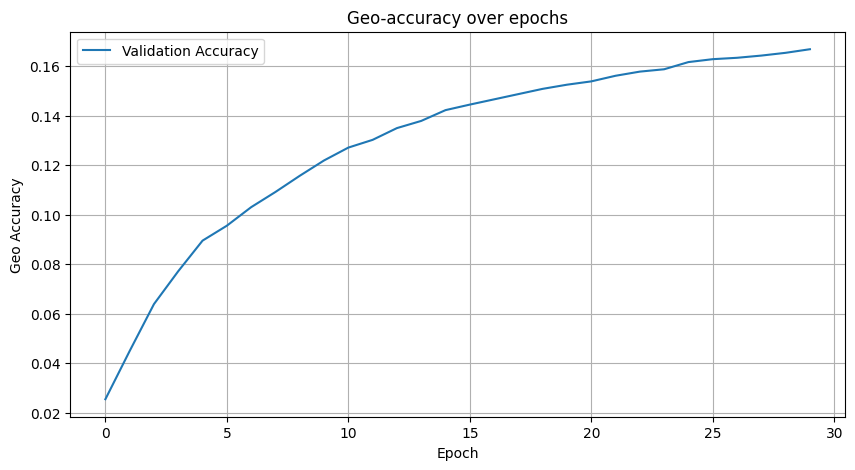

In [31]:
train_losses, train_accs, valid_losses, valid_accs, geo_history_val, geo_history_test = model_training(
    max_epochs=30,
    patience=5,
    model=model,
    train_iterator=train_loader,
    valid_iterator=val_loader,
    test_iterator=None,
    optimizer=optimizer,
    criterion=criterion,
    scaler=scaler,
    device=device,
    partition_idx=PARTITION_IDX,
    cell_centers_df=cell_centers_df,
    train_dataset_for_labels=train_dataset,
    geo_thresholds=(1, 5, 25, 100),
    model_name="first_try.pt",
    scheduler=scheduler
)



In [35]:
# ==========================================================
# 1. CREAZIONE DEL TEST SET E DEL TEST LOADER
# ==========================================================

# Usiamo lo split 'test'. Le trasformazioni devono essere le stesse
# usate per la validazione (senza data augmentation).
test_dataset = OSV_mini(
    image_root=path + '/test_images',
    csv_path="datasets/test_with_geocells_labels.csv",
    transform=train_transform, # Assicurati che train_transform sia Resize + ToTensor
    split='test'
)

test_loader = DataLoader(
    test_dataset,
    shuffle=False,
    batch_size=BATCH_SIZE,       # Usa la variabile BATCH_SIZE definita sopra
    num_workers=NUM_WORKERS,     # Usa NUM_WORKERS definito sopra
    pin_memory=True,
    prefetch_factor=PREFETCH_FACTOR,
    drop_last=False
)

# ==========================================================
# 2. VALUTAZIONE SUL TEST SET
# ==========================================================

# Soglie di errore in km che vogliamo monitorare
thresholds = [1, 5, 25, 100, 750, 2500]

print(f"Inizio valutazione sul Test Set ({len(test_dataset)} immagini)...")

# Se hai salvato il modello migliore durante il training, puoi caricarlo qui:
# model.load_state_dict(torch.load("first_try.pt"))

# Chiamata alla funzione di valutazione geografica
# NOTA: Passiamo train_dataset perché contiene le label_maps (mappe degli indici S2)
test_geo_accs = evaluate_geo(
    model,
    test_loader,
    device,
    cell_centers_df,
    train_dataset,
    thresholds
)

# ==========================================================
# 3. STAMPA DEI RISULTATI
# ==========================================================

print("\n" + "="*45)
print(f"{'REPORT FINALE: PERFORMANCE GEOGRAFICHE':^45}")
print("="*45)
for km, acc in test_geo_accs.items():
    print(f" Accuratezza entro {km:>4} km: {acc*100:7.2f}%")
print("="*45)

Inizio valutazione sul Test Set (10076 immagini)...



   REPORT FINALE: PERFORMANCE GEOGRAFICHE    
 Accuratezza entro    1 km:    0.00%
 Accuratezza entro    5 km:    0.01%
 Accuratezza entro   25 km:    0.12%
 Accuratezza entro  100 km:    0.32%
 Accuratezza entro  750 km:    0.69%
 Accuratezza entro 2500 km:    0.99%


In [ ]:
# from torch.utils.data import Subset
# import pandas as pd

# # ==========================================================
# # 1. CARICAMENTO DATI E FIX COLONNA (PER EVITARE KEYERROR)
# # ==========================================================
# test_csv_path = "/content/drive/MyDrive/osv5m/datasets/test_with_geocells_labels.csv"

# # Carichiamo il CSV e aggiungiamo is_train=0 se manca, salvando in un file temporaneo
# df_test_tmp = pd.read_csv(test_csv_path)
# if 'is_train' not in df_test_tmp.columns:
#     df_test_tmp['is_train'] = 0
#     df_test_tmp.to_csv("temp_test_fix.csv", index=False)
#     final_test_csv = "temp_test_fix.csv"
# else:
#     final_test_csv = test_csv_path

# # ==========================================================
# # 2. CREAZIONE DEL TEST DATASET (FULL)
# # ==========================================================
# full_test_dataset = OSV_mini(
#     image_root=path + '/test_images',
#     csv_path=final_test_csv,
#     transform=train_transform,
#     split='test'
# )

# # ==========================================================
# # 3. CREAZIONE DEL SUBSET (ES. 200 IMMAGINI)
# # ==========================================================
# N_TEST_SAMPLES = 200  # <--- Modifica questo numero per testare più o meno immagini
# indices = range(min(N_TEST_SAMPLES, len(full_test_dataset)))
# test_subset = Subset(full_test_dataset, indices)

# test_loader_mini = DataLoader(
#     test_subset,
#     shuffle=False,
#     batch_size=BATCH_SIZE,
#     num_workers=NUM_WORKERS,
#     pin_memory=True,
#     prefetch_factor=PREFETCH_FACTOR,
#     drop_last=False
# )

# # ==========================================================
# # 4. VALUTAZIONE SUL SUBSET
# # ==========================================================
# thresholds = [1, 5, 25, 100, 750, 2500]

# print(f"Inizio valutazione RAPIDA su Subset ({len(test_subset)} immagini)...")

# test_geo_accs = evaluate_geo(
#     model,
#     test_loader_mini, # <--- Usiamo il loader del subset
#     device,
#     cell_centers_df,
#     train_dataset,
#     thresholds
# )

# # ==========================================================
# # 5. STAMPA DEI RISULTATI
# # ==========================================================
# print("\n" + "="*45)
# print(f"{'REPORT TEST RAPIDO (SUBSET)':^45}")
# print("="*45)
# for km, acc in test_geo_accs.items():
#     print(f" Accuratezza entro {km:>4} km: {acc:7.2f}%")
# print("="*45)